<h1><center>App Rating Prediction</center></h1>

•	This code is used to predict rating of a app in the Google play store. The given dataframe has 13 columns like App name, Size, Reviews, Price etc. These features are used to predict the rating of a app using Linear Regression process.
•	First we do the EDA Exploratory Data Analysis which involves Data wrangling and Data sanitisation process before we do univariate analysis of the features and bivariate analysis of the Target variable with respect to the features.
•	The Size feature in the dataframe had some apps whose size varied upon the device, these were replaced by taking the mean size of the app according to the Category it was placed in.
•	There were outliers in all numeric data types which were removed by using the boxplot and applied log transformation which reduces the skewness in the data.
•	Then we applied the Linear regression on the sanitised dataframe and we predict the target variable Rating.
•	We find the R-Squared value to evaluate the model 


In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from mlxtend.evaluate import bias_variance_decomp

## 1. Load the data file using pandas.

In [2]:
app=pd.read_csv('../input/google-play-store-apps/googleplaystore.csv')

In [3]:
app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [4]:
app.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [5]:
app.shape

(10841, 13)

## 2. Check for null values in the data. Get the number of null values for each column.

In [6]:
app.isnull().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

## 3. Drop records with nulls in any of the columns.

In [7]:
app.dropna(inplace= True)
app.isnull().sum()
app.shape

(9360, 13)

## 4.Variables seem to have incorrect type and inconsistent formatting. Need to fix them.

### 1.Converting Size into numeric

In [8]:
app.Size.value_counts()

Varies with device    1637
14M                    165
12M                    161
15M                    159
11M                    159
                      ... 
383k                     1
454k                     1
812k                     1
442k                     1
619k                     1
Name: Size, Length: 413, dtype: int64

In [9]:
def Mb_to_kb(size):
     if size.endswith('k'):
         return float(size[:-1])
     elif size.endswith('M'):
         return float(size[:-1])*1000
     else:
         return size

In [10]:
app['Size'] = app['Size'].replace(['Varies with device'],'Nan')
app['Size'] = app['Size'].apply(lambda x: Mb_to_kb(x))
app['Size'] = app['Size'].astype(float)
app['Size'].fillna(app.groupby('Category')['Size'].transform('mean'),inplace = True)

### 2.Converting Reviews into numeric

In [11]:
app['Reviews']=app["Reviews"].astype(int)

### 3.Converting Installs into numeric
Installs field is currently stored as string and has values like 1,000,000+. 
Treat 1,000,000+ as 1,000,000
remove ‘+’, ‘,’ from the field, convert it to integer

In [12]:
app['Installs']=app['Installs'].apply(lambda x:x.replace(",",''))
app['Installs']=app['Installs'].apply(lambda x:x.replace("+",''))
app['Installs']=app['Installs'].astype(int)

### 4. Converting Price into numeric 

In [13]:
app['Price']=app['Price'].apply(lambda x:x.replace("$",''))
app['Price']=app['Price'].astype(float)

## 5. Sanity checks:

### 1.Rating between 1 and 5
Average rating should be between 1 and 5 as only these values are allowed on the play store. Dropping the rows that have a value outside this range.

In [14]:
len(app[(app['Rating'] < 1) & (app['Rating'] > 5)])

0

In [15]:
app.shape

(9360, 13)

### 2.Reviews and Installs
Reviews and Installs should not be more than installs as only those who installed can review the app.
Dropping those Reviews more than Installs

In [16]:
len(app[app.Installs<app.Reviews])

7

In [17]:
i3=app[app.Installs<app.Reviews].Installs.index

In [18]:
app.drop(axis=0 ,index=i3, inplace=True)

In [19]:
app.shape

(9353, 13)

### 3.Price
For free apps (type = “Free”), the price should not be >0
Dropping any such rows.

In [20]:
len(app[(app['Type'] == 'Free') & (app['Price'] != 0)])


0

## 5.Performing univariate analysis.

### > Boxplot for Price

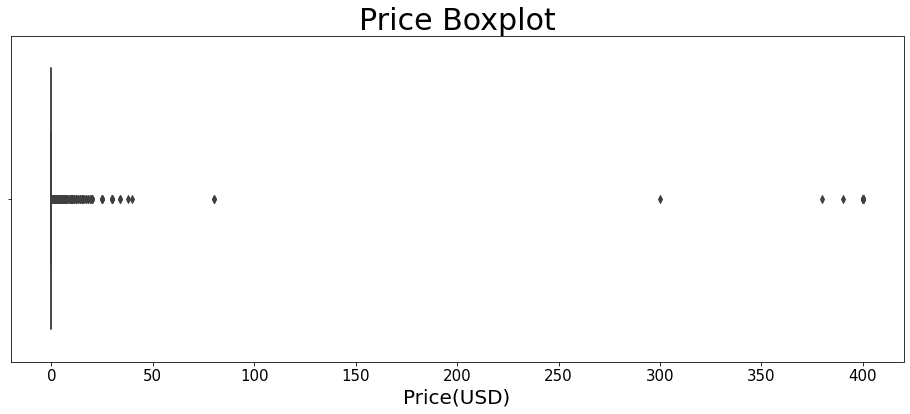

In [21]:
plt.figure(figsize=(16, 6))
b=sns.boxplot(app.Price)
b.axes.set_title("Price Boxplot",fontsize=30)
b.set_xlabel("Price(USD)",fontsize=20)
b.tick_params(labelsize=15)


There are outliers in the Price,app prices are usually free or below $10.

### > Boxplot for Reviews

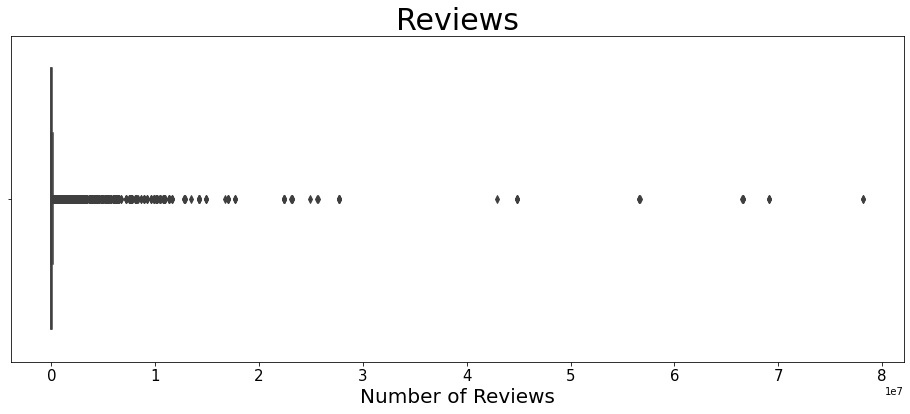

In [22]:
plt.figure(figsize=(16, 6))
b=sns.boxplot(app.Reviews)
b.axes.set_title("Reviews",fontsize=30)
b.set_xlabel("Number of Reviews",fontsize=20)
b.tick_params(labelsize=15)

There are some apps with very high number of reviews, they dont seem right as most app have reviews less than 100,000.

### > Histogram for Rating

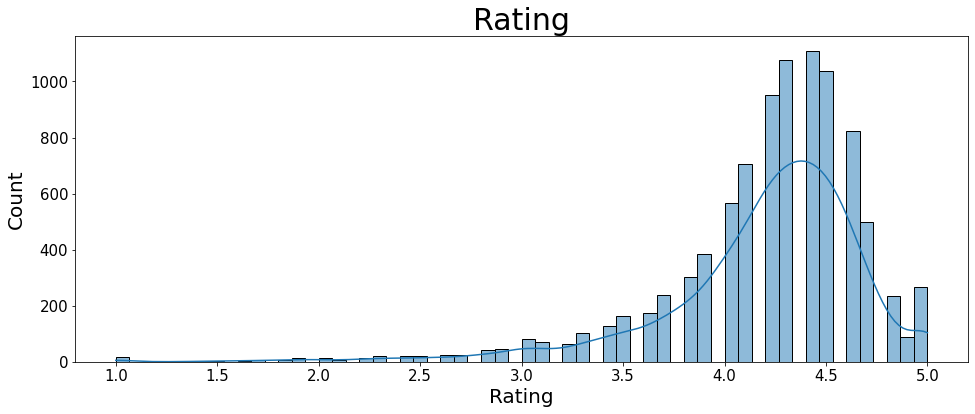

In [23]:
plt.figure(figsize=(16, 6))
h=sns.histplot(app.Rating,bins=60,kde=True)
h.axes.set_title("Rating",fontsize=30)
h.set_xlabel("Rating",fontsize=20)
h.set_ylabel("Count",fontsize=20)
h.tick_params(labelsize=15)

The ratings are normally distributed but they are left skewed and are towards higher ratings

### > Histogram for Size

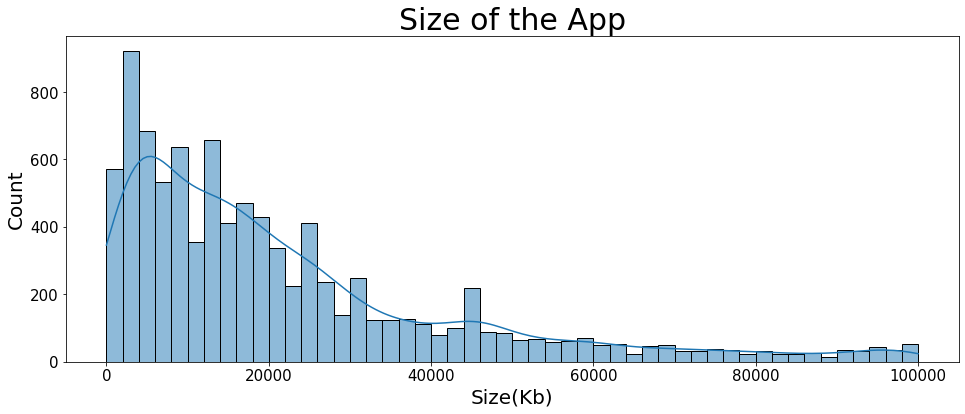

In [24]:
plt.figure(figsize=(16, 6))
h=sns.histplot(app.Size,bins=50,kde=True)
h.axes.set_title("Size of the App",fontsize=30)
h.set_xlabel("Size(Kb)",fontsize=20)
h.set_ylabel("Count",fontsize=20)
h.tick_params(labelsize=15)

There are outliers in all the above plots

## 6. Outlier treatment

### 1.Price: 
From the box plot, it seems like there are some apps with very high price. A price of $200 for an application on the Play Store is very high and suspicious.
Checking out the records with very high price and dropping such high priced apps

In [25]:
app.Price.quantile([0.1,0.25,0.50,0.75,0.90,0.95,0.99])

0.10    0.00
0.25    0.00
0.50    0.00
0.75    0.00
0.90    0.00
0.95    1.99
0.99    8.99
Name: Price, dtype: float64

In [26]:
len(app[app.Price >=200])

15

In [27]:
app.Price.mean()

0.9614669090131416

The mean Price of all the apps is $ 0.96, $ 200 is indeed very high price for a app.

In [28]:
i7=app[app.Price >=200].Price.index

In [29]:
app.drop(axis=0 ,index=i7, inplace=True)

In [30]:
app.shape

(9338, 13)

### 2.Reviews
Very few apps have very high number of reviews. 
These are all star apps that don’t help with the analysis and, in fact, will skew it. 
Dropping records having more than 2 million reviews.

In [31]:
len(app[app.Reviews >=2000000])

453

In [32]:
i8=app[app.Reviews >=2000000].Reviews.index


In [33]:
app.drop(axis=0 ,index=i8, inplace=True)

In [34]:
app.shape

(8885, 13)

### 3.Installs
There seems to be some outliers in this field too. 
 Apps having very high number of installs should be dropped from the analysis.
Finding out the different percentiles – 10, 25, 50, 70, 90, 95, 99
Deciding a threshold as cutoff for outlier and drop records having values more than that

In [35]:
app.Installs.quantile([0.1,0.25,0.50,0.75,0.90,0.95,0.99])

0.10         1000.0
0.25        10000.0
0.50       500000.0
0.75      5000000.0
0.90     10000000.0
0.95     10000000.0
0.99    100000000.0
Name: Installs, dtype: float64

In [36]:
min_threshold,max_threshold=app.Installs.quantile([0.05,0.95])
inp=app[(app.Installs>min_threshold) & (app.Installs<max_threshold)]

In [37]:
inp.shape

(6618, 13)

## 7.Bivariate analysis

### 1.Scatter plot/joinplot for Rating vs. Price

Text(40.25, 0.5, 'Rating')

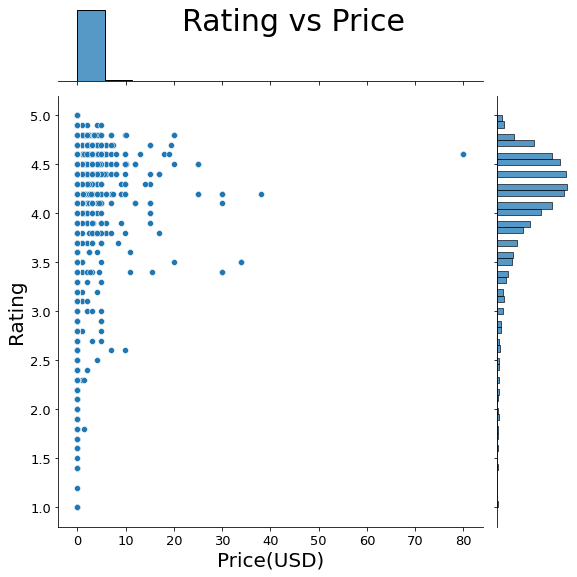

In [38]:
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
j=sns.jointplot(y = "Rating", x = "Price", data = inp,height=8)
j.fig.suptitle("Rating vs Price",fontsize=30)
j.ax_joint.set_xlabel('Price(USD)',fontsize=20)
j.ax_joint.set_ylabel('Rating',fontsize=20)

### 2. Scatter plot/joinplot for Rating vs. Size

Text(40.25, 0.5, 'Rating')

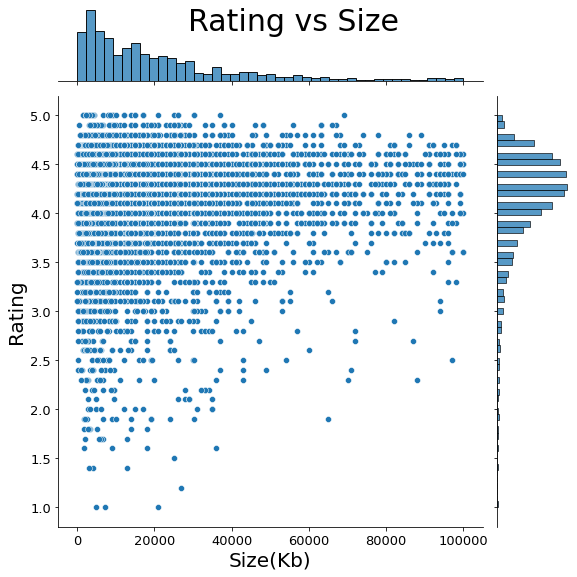

In [39]:
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
j=sns.jointplot(y = "Rating", x = "Size", data = inp,height=8)
j.fig.suptitle("Rating vs Size",fontsize=30)
j.ax_joint.set_xlabel('Size(Kb)',fontsize=20)
j.ax_joint.set_ylabel('Rating',fontsize=20)

### 3.Scatter plot/joinplot for Rating vs. Reviews

Text(40.25, 0.5, 'Rating')

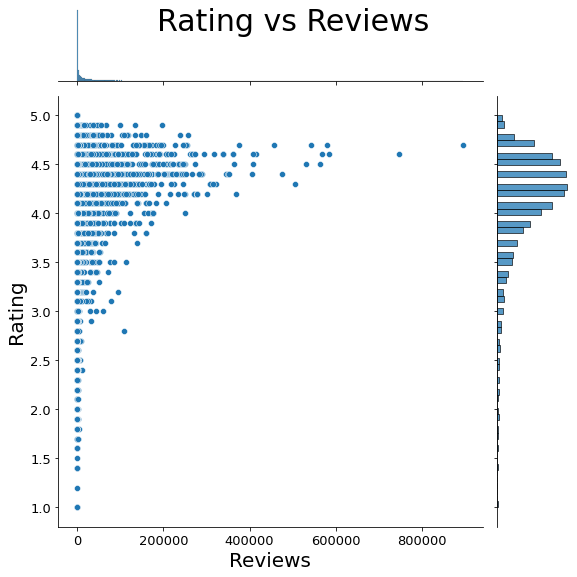

In [40]:
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
j=sns.jointplot(y = "Rating", x = "Reviews", data = inp,height=8)
j.fig.suptitle("Rating vs Reviews",fontsize=30)
j.ax_joint.set_xlabel('Reviews',fontsize=20)
j.ax_joint.set_ylabel('Rating',fontsize=20)

### 4.Boxplot for Rating vs. Content Rating

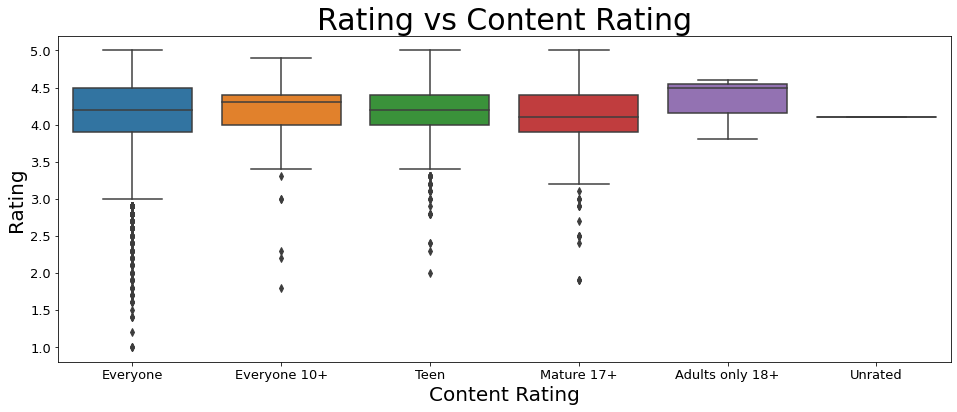

In [41]:
plt.figure(figsize=(16,6))
h=sns.boxplot( x='Content Rating',y='Rating',data=inp)
h.axes.set_title("Rating vs Content Rating",fontsize=30)
h.set_xlabel("Content Rating",fontsize=20)
h.set_ylabel("Rating",fontsize=20)
h.tick_params(labelsize=13)

### 5.Boxplot for Rating vs. Category

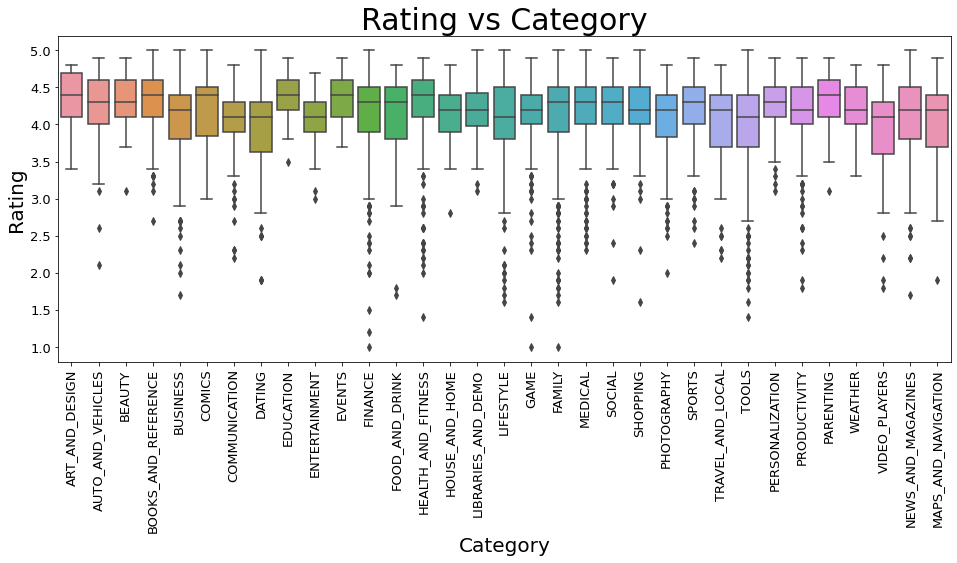

In [42]:
plt.figure(figsize=(16,6))
h=sns.boxplot( x='Category',y='Rating',data=inp)
h.axes.set_title("Rating vs Category",fontsize=30)
h.set_xlabel("Category",fontsize=20)
h.set_ylabel("Rating",fontsize=20)
h.tick_params(labelsize=13)
plt.xticks(rotation=90);

In [43]:
groupCat = inp.groupby('Category')
mean_df=groupCat.mean()
mean_df = mean_df.reset_index()
mean_df.sort_values(by='Rating',ascending=False).head(3)

,Category,Rating,Reviews,Size,Installs,Price
8,EDUCATION,4.363636,38841.975207,20602.355522,1.416132e+06,0.148430
10,EVENTS,4.358824,4720.294118,13704.820433,4.690000e+05,0.000000
0,ART_AND_DESIGN,4.355556,8601.018519,12232.215837,4.486667e+05,0.110556


In [44]:
inp1=inp.copy(deep=True)

## 8. Data preprocessing

### 1.Reviews and Install 
Reviews and Install have some values that are still relatively very high.
Before building a linear regression model, we need to reduce the skew. 
Applying log transformation (np.log1p) to Reviews and Installs.

In [45]:
inp1['Installs']= np.log1p(inp1['Installs'])
inp1['Reviews']= np.log1p(inp1['Reviews'])

Text(0.5, 1.0, 'Reviews')

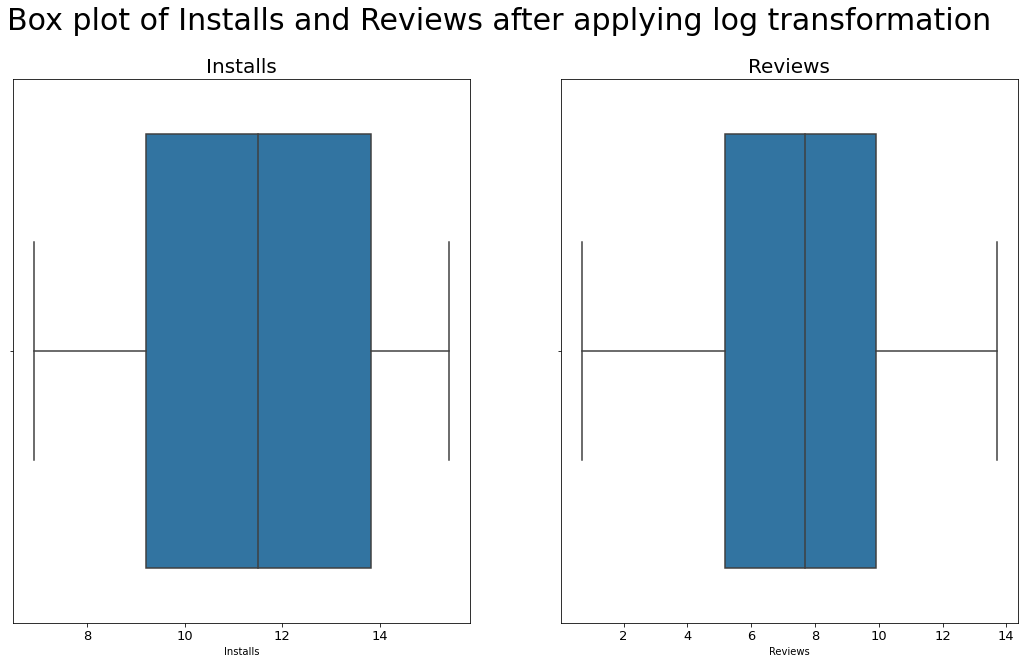

In [46]:
fig, axes = plt.subplots(1,2, figsize=(18, 10))
fig.suptitle('Box plot of Installs and Reviews after applying log transformation',fontsize=30)
sns.boxplot( inp1.Installs,ax=axes[0])
sns.boxplot( inp1.Reviews,ax=axes[1],)
axes[0].set_title("Installs",fontsize=20)
axes[1].set_title("Reviews",fontsize=20)

### 2.Dropping unwanted Columns 
Dropping columns App, Last Updated, Current Ver, Type and Android Ver.
These variables are not useful for our task.

In [47]:
inp1.drop(['App','Last Updated','Current Ver','Android Ver','Type'],axis=1,inplace=True)


In [48]:
inp1.shape

(6618, 8)

In [49]:
inp1.head()

,Category,Rating,Reviews,Size,Installs,Price,Content Rating,Genres
0,ART_AND_DESIGN,4.1,5.075174,19000.0,9.210440,0.0,Everyone,Art & Design
1,ART_AND_DESIGN,3.9,6.875232,14000.0,13.122365,0.0,Everyone,Art & Design;Pretend Play
2,ART_AND_DESIGN,4.7,11.379520,8700.0,15.424949,0.0,Everyone,Art & Design
4,ART_AND_DESIGN,4.3,6.875232,2800.0,11.512935,0.0,Everyone,Art & Design;Creativity
5,ART_AND_DESIGN,4.4,5.123964,5600.0,10.819798,0.0,Everyone,Art & Design


### 3.Dummy Columns
Getting the dummy columns for Category, Genres, and Content Rating.Dummy encoding is one way to convert character fields to numeric. Name of dataframe is inp2.

In [50]:
cat_cols = ['Category', 'Content Rating','Genres']
inp2 = pd.get_dummies(inp1, columns=cat_cols, drop_first=True)
inp2.head()

,Rating,Reviews,Size,Installs,Price,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,...,Genres_Strategy;Education,Genres_Tools,Genres_Travel & Local,Genres_Travel & Local;Action & Adventure,Genres_Trivia,Genres_Video Players & Editors,Genres_Video Players & Editors;Creativity,Genres_Video Players & Editors;Music & Video,Genres_Weather,Genres_Word
0,4.1,5.075174,19000.0,9.210440,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.9,6.875232,14000.0,13.122365,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.7,11.379520,8700.0,15.424949,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.3,6.875232,2800.0,11.512935,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4.4,5.123964,5600.0,10.819798,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 9. Train test split  and apply 70-30 split. Name the new dataframes df_train and df_test.

In [51]:
df_train, df_test = train_test_split(inp2, train_size=0.70, random_state=0)
df_train.shape,df_test.shape

((4632, 150), (1986, 150))

## 10. Separate the dataframes into X_train, y_train, X_test, and y_test.

In [52]:
y_train=df_train.Rating
X_train=df_train.drop(['Rating'],axis=1)

In [53]:
y_test=df_test.Rating
X_test=df_test.drop(['Rating'],axis=1)

In [54]:
X_train.shape,X_test.shape

((4632, 149), (1986, 149))

## 11.Model building


### Using linear regression as the technique

### Report the R2 on the train set

In [55]:
reg =LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [56]:
y_pred= reg.predict(X_train)
print('\nR2 on train set: %.2f' % r2_score(y_train, y_pred).round(decimals=2))



R2 on train set: 0.17


## 12. Make predictions on test set and report R2.

In [57]:
y_pred2=reg.predict(X_test)
r2=r2_score(y_test,y_pred2).round(decimals=2)

In [58]:
print('\nR2: %.2f' % r2)

print('\nMean Squared Error: %.2f'
      % mean_squared_error(y_test, y_pred2))

print("\nRoot Mean Squared Error",np.sqrt(mean_squared_error(y_test,y_pred2)).round(decimals=2))



R2: 0.15

Mean Squared Error: 0.23

Root Mean Squared Error 0.47


In [59]:
dfReg = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred2,'Difference':y_test-y_pred2})
dfReg

,Actual,Predicted,Difference
7200,3.4,3.890554,-0.490554
9236,3.0,3.934422,-0.934422
2983,4.3,4.263932,0.036068
7146,4.2,3.917974,0.282026
5962,4.4,4.164622,0.235378
...,...,...,...
271,3.8,4.099635,-0.299635
2183,4.4,4.399944,0.000056
5726,3.5,4.106412,-0.606412
4298,4.5,4.077367,0.422633


In [60]:
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(reg, X_train.values,
                                                            y_train.values, X_test.values,
                                                            y_test.values,
                                                            loss='mse',
                                                            num_rounds=50,
                                                            random_seed=20)
 

In [61]:
print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 0.229
Average bias: 0.226
Average variance: 0.004


1.	R-squared (r2 score) is a statistical measure of how close the data are to the fitted regression line. The r2 score here is 0.15 which is quite low for a linear regression model, but there is a definite correlation between the given features and the target variable Rating

2.	One of the reasons for low r2 score could be strong multicollinearity between the features. This can be tackled by Principal Component Analysis as it reduces the dimensions and eliminates the multicollinearity by making the features linearly independent to each other. The multicollinearity can also be reduced by variable inflation factor process.

3.	The mean squared error is 0.23 which is acceptable for our prediction model.


4.	There is Underfitting in the model as there is high Bias and low Variance. Bias is the model’s inability to learn enough about the relationship between the model’s features and labels, while the variance captures the model’s inability to generalize on new, unseen examples. This model has high bias oversimplifying the relationship and is said to be underfit.

Here is the dataframe of actual and predicted Rating of a app. We can observe that for some app the model predicts with zero error and has errors while predicting for others.

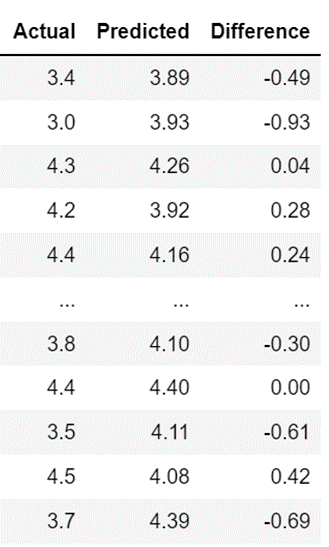